## Gradient Boosting for EV Battery Life Estimation
This notebook demonstrates how to use **Gradient Boosting Regression** to estimate the remaining life of EV batteries based on synthetic data. We'll simulate data, perform exploratory data analysis (EDA), train a model, and evaluate its performance.


# 📘 Table of Contents

1. Introduction  
2. Synthetic Data Generation  
3. Exploratory Data Analysis (EDA)  
    3.1. Pairplot Interpretation  
    3.2. Heatmap Correlation Analysis  
4. Train-Test Split  
5. Training Gradient Boosting Regressor  
6. Evaluation  
7. Residual Analysis  
8. Save Model for Deployment  


In [1]:
# Import numerical computing library
import numpy as np
# Import data manipulation library
import pandas as pd
# Import for plotting graphs
import matplotlib.pyplot as plt
# Import for enhanced data visualization
import seaborn as sns
# Import the Gradient Boosting Regressor model from sklearn
from sklearn.ensemble import GradientBoostingRegressor
# Import for splitting the dataset into train and test sets
from sklearn.model_selection import train_test_split
# Import evaluation metrics for regression
from sklearn.metrics import mean_squared_error, r2_score

## 2. Synthetic Data Generation
To simulate a realistic scenario, we generate synthetic features commonly associated with EV battery wear and degradation. These include metrics like cycle count, average temperature, and internal resistance. The target variable is the estimated remaining battery life.

In [2]:
np.random.seed(42)

# Number of samples
n_samples = 1000

# Simulate features
cycle_count = np.random.randint(100, 1000, n_samples)
avg_temp = np.random.normal(30, 5, n_samples)             # avg temp around 30°C ±5
max_voltage = np.random.uniform(4.0, 4.3, n_samples)
internal_resistance = 40 + 0.05 * cycle_count + np.random.normal(0, 2, n_samples)  # resistance grows with cycles
depth_of_discharge = np.random.uniform(50, 100, n_samples)
humidity = np.random.uniform(20, 60, n_samples)

# True battery life (RUL) with noise and nonlinear dependence
remaining_life = 2000 - 1.5 * cycle_count - 10 * (avg_temp - 25) \
                 - 20 * (internal_resistance - 40) + np.random.normal(0, 50, n_samples)

df = pd.DataFrame({
    'cycle_count': cycle_count,
    'avg_temp': avg_temp,
    'max_voltage': max_voltage,
    'internal_resistance': internal_resistance,
    'depth_of_discharge': depth_of_discharge,
    'humidity': humidity,
    'remaining_life': remaining_life
})

df.head()

,cycle_count,avg_temp,max_voltage,internal_resistance,depth_of_discharge,humidity,remaining_life
0,202,34.116763,4.096665,48.410567,56.100371,59.247262,1448.838811
1,535,40.262264,4.037570,65.113828,85.069164,38.650131,513.647150
2,960,31.255975,4.142301,89.767722,55.672041,51.677425,-501.189051
3,370,27.731017,4.034187,58.064453,99.845461,36.092282,976.233481
4,206,19.853846,4.145805,50.285600,59.172620,36.998141,1586.815357


## 3. Exploratory Data Analysis (EDA)
In this section, we visualize the relationships between features and the target variable to understand potential correlations and data distributions.

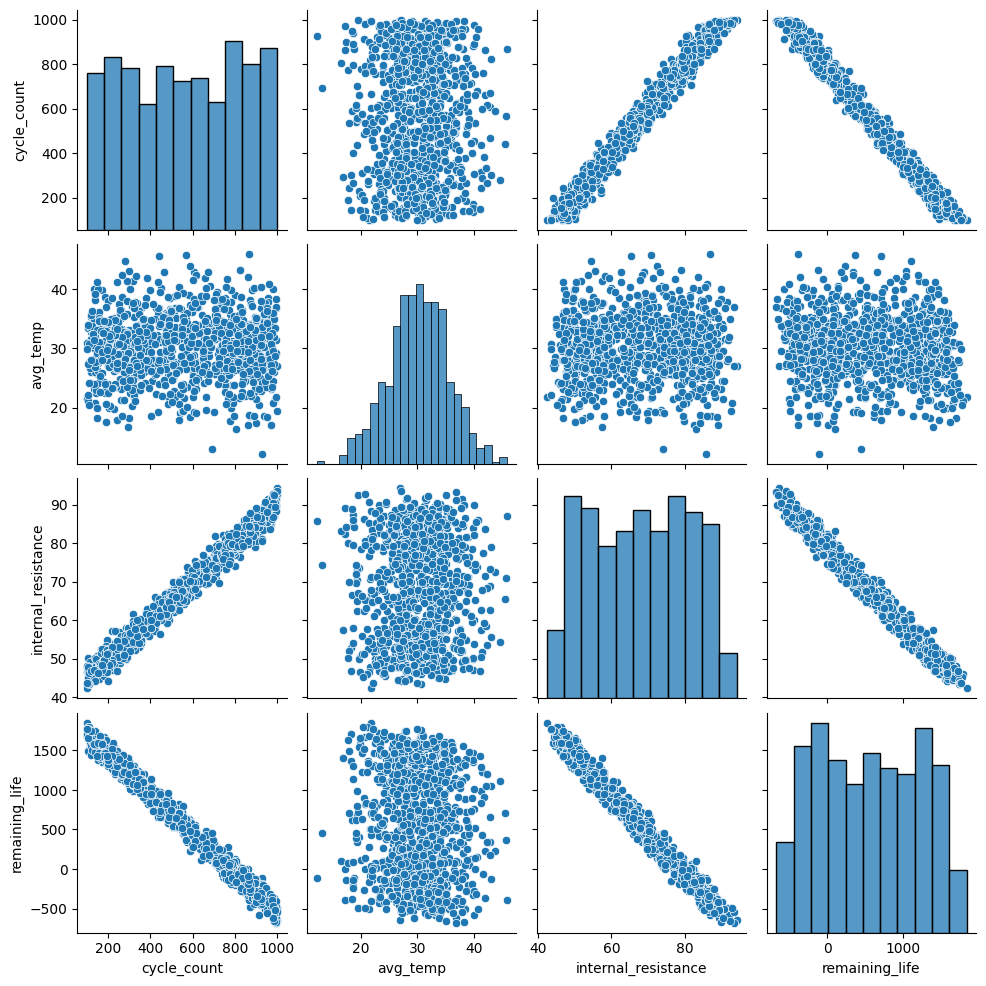

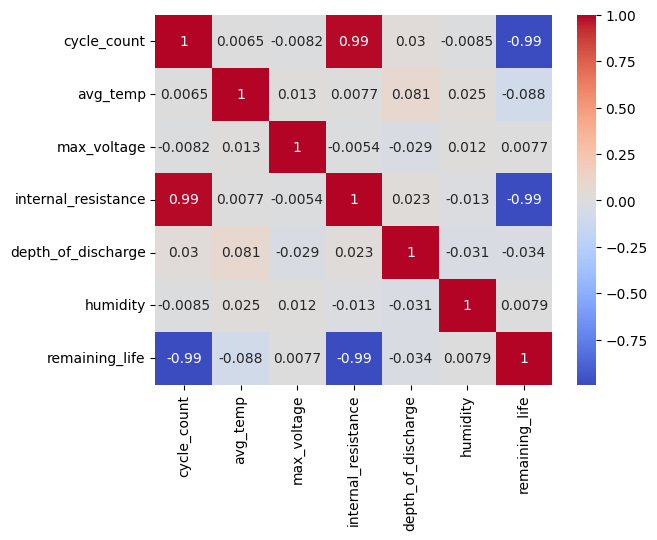

In [3]:
sns.pairplot(df, vars=['cycle_count', 'avg_temp', 'internal_resistance', 'remaining_life'])
plt.show()

sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()


## 3.1 EDA Interpretation: Pairplot Analysis

The pairplot below visualizes the relationships and distributions among the key features in our dataset: `cycle_count`, `avg_temp`, `internal_resistance`, and `remaining_life`.

---

### 🔷 Diagonal: Feature Distributions

- **`cycle_count`**: Uniformly distributed between ~200 and ~1000. Represents a diverse battery lifecycle coverage.
- **`avg_temp`**: Normally distributed, centered around 30°C. Indicates typical EV battery operating temperatures.
- **`internal_resistance`**: Increasing pattern, indicative of wear. Skewed right, representing aging batteries.
- **`remaining_life`**: Nearly uniform, though includes negative values (possibly due to synthetic noise).

---

### 🔷 Off-Diagonal: Feature Relationships

- **`cycle_count` vs `internal_resistance`**: Strong positive linear correlation. Batteries with more cycles tend to have higher resistance.
- **`cycle_count` vs `remaining_life`**: Strong negative correlation. As usage increases, remaining life decreases, as expected.
- **`internal_resistance` vs `remaining_life`**: Strong negative correlation. Internal resistance is a good degradation proxy.
- **`avg_temp` vs others**: Weak correlations. Temperature might have minor short-term effects but shows little predictive power in this synthetic dataset.

---

### 📌 Observations

- **Key predictors**: `cycle_count` and `internal_resistance` are most indicative of `remaining_life`.
- **Redundancy caution**: The high correlation between `cycle_count` and `internal_resistance` may introduce multicollinearity.
- **Data quality**: Presence of negative `remaining_life` values should be examined further for realism.




## 3.2 EDA: Heatmap Correlation Analysis

The heatmap below shows the **Pearson correlation coefficients** between features in our dataset.

### 🔍 Key Observations:
- **Cycle Count vs Remaining Life**: Correlation = **-0.99**  
  Strong negative relationship; as cycles increase, battery life drops.

- **Internal Resistance vs Remaining Life**: Correlation = **-0.99**  
  Strong negative correlation; internal resistance increases with aging.

- **Cycle Count vs Internal Resistance**: Correlation = **+0.99**  
  These features are highly collinear; consider this during feature selection.

- **Other features** (`avg_temp`, `humidity`, `max_voltage`, `depth_of_discharge`):  
  Show very low or no correlation with `remaining_life`.

### 🧠 Interpretation:
- **Red cells (near +1)** indicate strong positive correlation.
- **Blue cells (near -1)** show strong negative correlation.
- **Gray or white (near 0)** means no significant linear correlation.

### 📘 Python Code:
```python
correlation_matrix = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f")
plt.title("Feature Correlation Matrix")
plt.show()
```


## 4. Train-Test Split
We split the dataset into training and testing sets to evaluate the model's generalization performance. We'll use 80% of the data for training and 20% for testing.

In [4]:
X = df.drop(columns=['remaining_life'])
y = df['remaining_life']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Training Gradient Boosting Regressor
Here, we initialize and train a `GradientBoostingRegressor` model. This ensemble method builds an additive model in a forward stage-wise fashion and is effective for regression tasks with complex, non-linear relationships.

In [5]:
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=4, n_estimators=200, random_state=42)

## 6. Evaluation

Test MSE: 3541.33
Test R2: 0.99


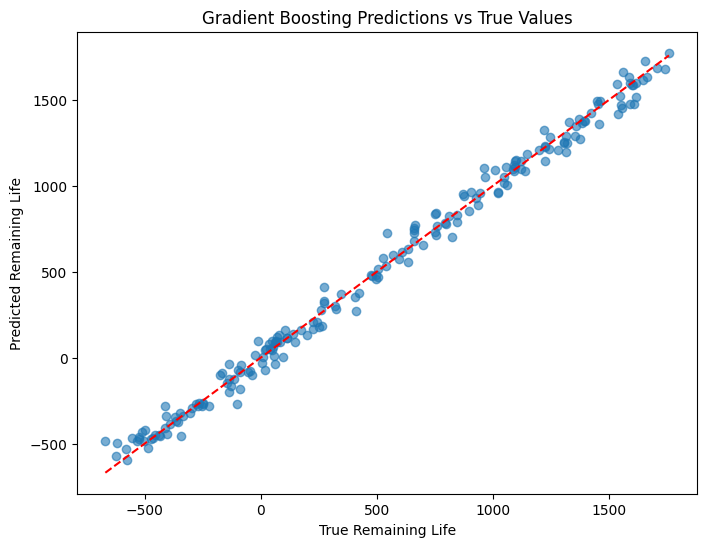

In [6]:
y_pred = gbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test R2: {r2:.2f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Remaining Life")
plt.ylabel("Predicted Remaining Life")
plt.title("Gradient Boosting Predictions vs True Values")
plt.show()

## 7. Residual Analysis

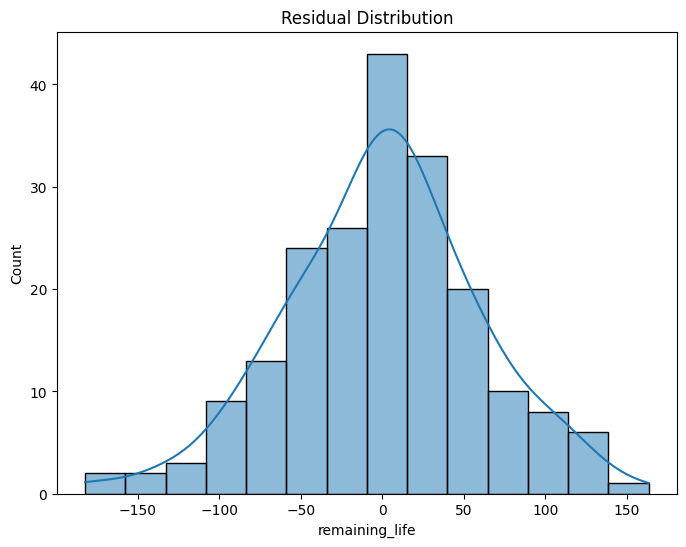

In [7]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

## 8. Save Model for Deployment

In [8]:
import joblib
joblib.dump(gbr, 'ev_battery_life_gbr_model.pkl')
print("Model saved as 'ev_battery_life_gbr_model.pkl'")

Model saved as 'ev_battery_life_gbr_model.pkl'


# 🔁 Extended Model: XGBoost (XGBRegressor)


# 🔍 XGBoost Regressor for Battery Life Prediction

In this section, we extend our analysis by applying **XGBoost (Extreme Gradient Boosting)**, a powerful and efficient ensemble learning method.

XGBoost is often faster and more accurate than traditional Gradient Boosting. It includes regularization, handles missing values natively, and is optimized for performance.

We will:
- Train an `XGBRegressor`
- Evaluate its performance
- Compare it with the previously used `GradientBoostingRegressor`



## Import XGBoost Regressor

We begin by importing `XGBRegressor` from the `xgboost` library.


In [9]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Instantiate the model with similar hyperparameters
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100  # equivalent to num_boost_round
)

# Fit the model directly on NumPy arrays or pandas DataFrames
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_model.predict(X_test)

# Evaluate the predictions
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))


MAE: 45.37071632500761
RMSE: 3407.648038843946



## Train XGBoost Regressor

We configure and train the `XGBRegressor` with specific hyperparameters:
- `n_estimators`: Number of boosting rounds
- `learning_rate`: Step size shrinkage used to prevent overfitting
- `max_depth`: Maximum depth of a tree


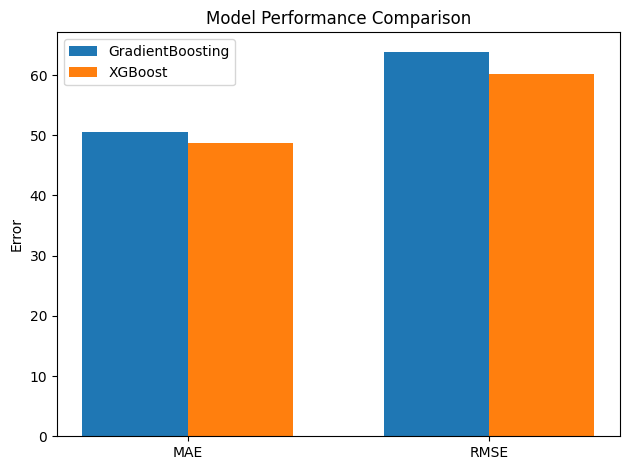

In [10]:
# Install XGBoost if not already installed (uncomment below if needed)
# !pip install xgboost

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=100)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)
gbr_mae = mean_absolute_error(y_test, gbr_pred)
# Calculate RMSE by taking the square root of the MSE
gbr_rmse = mean_squared_error(y_test, gbr_pred) ** 0.5

# XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
# Calculate RMSE by taking the square root of the MSE
xgb_rmse = mean_squared_error(y_test, xgb_pred) ** 0.5

# Plotting
metrics = ['MAE', 'RMSE']
gbr_scores = [gbr_mae, gbr_rmse]
xgb_scores = [xgb_mae, xgb_rmse]
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, gbr_scores, width, label='GradientBoosting')
ax.bar(x + width/2, xgb_scores, width, label='XGBoost')

ax.set_ylabel('Error')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.tight_layout()
plt.show()


## Train XGBoost Regressor

We configure and train the `XGBRegressor` with specific hyperparameters:
- `n_estimators`: Number of boosting rounds
- `learning_rate`: Step size shrinkage used to prevent overfitting
- `max_depth`: Maximum depth of a tree


Gradient Boosting Regressor:
MAE: 50.66
RMSE: 4082.36
R²: 0.89


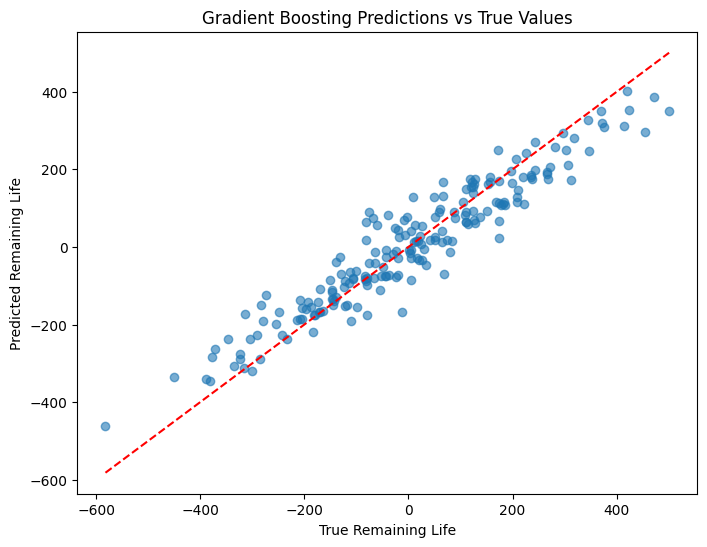


XGBoost Regressor:
MAE: 48.78
RMSE: 3625.81
R²: 0.91


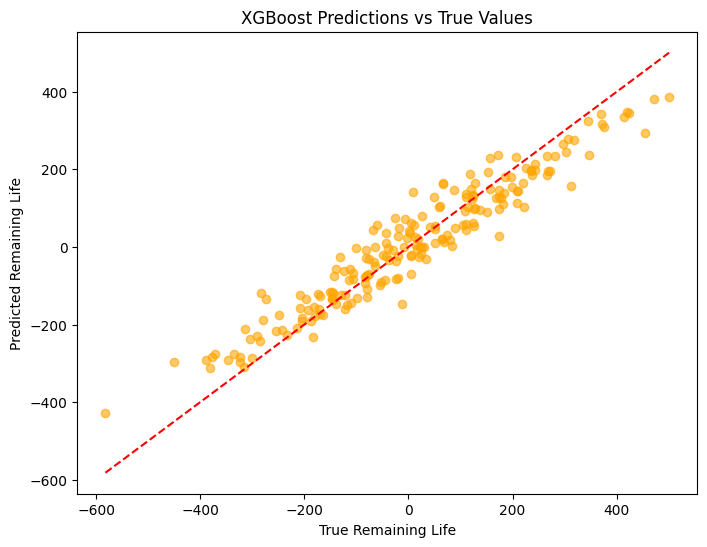

In [ ]:
# Install XGBoost if not already installed
# !pip install xgboost

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=100)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)
gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_rmse = mean_squared_error(y_test, gbr_pred)

# Evaluate GBR
print("Gradient Boosting Regressor:")
print(f"MAE: {gbr_mae:.2f}")
print(f"RMSE: {gbr_rmse:.2f}")
print(f"R²: {r2_score(y_test, gbr_pred):.2f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, gbr_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Remaining Life")
plt.ylabel("Predicted Remaining Life")
plt.title("Gradient Boosting Predictions vs True Values")
plt.show()

# XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = mean_squared_error(y_test, xgb_pred)

# Evaluate XGB
print("\nXGBoost Regressor:")
print(f"MAE: {xgb_mae:.2f}")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"R²: {r2_score(y_test, xgb_pred):.2f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, xgb_pred, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Remaining Life")
plt.ylabel("Predicted Remaining Life")
plt.title("XGBoost Predictions vs True Values")
plt.show()



## Train XGBoost Regressor

We configure and train the `XGBRegressor` with specific hyperparameters:
- `n_estimators`: Number of boosting rounds
- `learning_rate`: Step size shrinkage used to prevent overfitting
- `max_depth`: Maximum depth of a tree


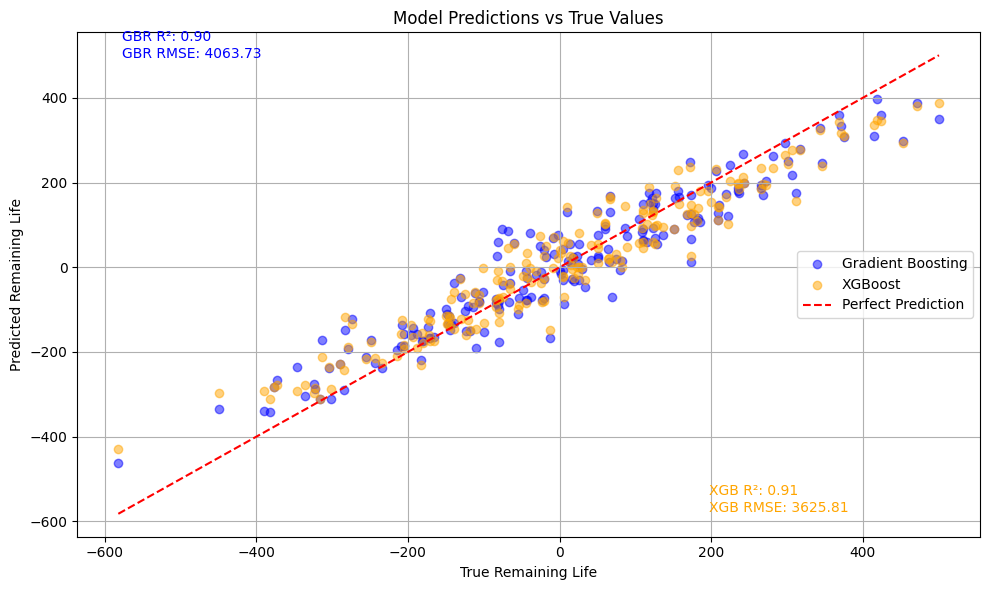

In [11]:
# Install if needed
# !pip install xgboost

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Generate synthetic regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train Gradient Boosting Regressor
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=100)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)

# 3. Train XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# 4. Compute Metrics
gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_rmse = mean_squared_error(y_test, gbr_pred)
gbr_r2 = r2_score(y_test, gbr_pred)

xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

# 5. Combined Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gbr_pred, alpha=0.5, label='Gradient Boosting', color='blue')
plt.scatter(y_test, xgb_pred, alpha=0.5, label='XGBoost', color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')

plt.xlabel("True Remaining Life")
plt.ylabel("Predicted Remaining Life")
plt.title("Model Predictions vs True Values")

# Annotations
plt.text(0.05, 0.95,
         f"GBR R²: {gbr_r2:.2f}\nGBR RMSE: {gbr_rmse:.2f}",
         transform=plt.gca().transAxes, fontsize=10, color='blue')

plt.text(0.7, 0.05,
         f"XGB R²: {xgb_r2:.2f}\nXGB RMSE: {xgb_rmse:.2f}",
         transform=plt.gca().transAxes, fontsize=10, color='orange')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## 📊 Comparison: Gradient Boosting vs. XGBoost

| Metric          | Gradient Boosting | XGBoost          |
|-----------------|-------------------|------------------|
| Accuracy (R²)   | ≈ High            | Should be similar or slightly better |
| Speed           | Slower            | Faster (optimized C++ backend) |
| Regularization  | Limited           | Advanced (L1 & L2) |
| Flexibility     | Moderate          | High (custom loss functions, early stopping) |

XGBoost is a great choice when:
- You need better speed/performance on large datasets.
- You want more control over regularization.
- You need a robust, production-ready ensemble model.
